## **Fetching Data**

We can use `yfinance` to download ticker data. To start, we can follow the three-fund portfolio and have some US stocks (e.g. VTSAX), some international stocks (e.g. VXUS), and bonds (e.g. BND). I plan to convert this later into scripts properly.

In [2]:
from datetime import datetime
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from cycler import cycler
import sqlite3
from sklearn.mixture import GaussianMixture

In [3]:
tickers = ["VTI", "VXUS", "BND"]
data = yf.download(tickers, period="10y", interval="1d")

data

[*********************100%***********************]  3 of 3 completed


Price           Close                              High              \
Ticker            BND         VTI       VXUS        BND         VTI   
Date                                                                  
2016-02-01  61.120087   83.425003  31.303993  61.300314   83.815195   
2016-02-02  61.330330   81.813347  30.589024  61.367880   82.746423   
2016-02-03  61.375378   82.305328  30.979675  61.525566   82.525874   
2016-02-04  61.420437   82.500427  31.127100  61.473003   83.060266   
2016-02-05  61.360386   80.803932  30.706951  61.427975   82.279879   
...               ...         ...        ...        ...         ...   
2026-01-26  74.339996  342.029999  79.860001  74.379997  342.670013   
2026-01-27  74.279999  343.269989  81.099998  74.379997  343.730011   
2026-01-28  74.250000  343.079987  80.739998  74.260002  344.420013   
2026-01-29  74.260002  342.290009  80.949997  74.320000  343.829987   
2026-01-30  74.230003  340.570007  79.660004  74.300003  342.040009   

Price                        Low                              Open  \
Ticker           VXUS        BND         VTI       VXUS        BND   
Date                                                                 
2016-02-01  31.429296  61.075031   82.593725  31.009158  61.217709   
2016-02-02  30.950196  61.262747   81.567361  30.485832  61.330330   
2016-02-03  30.987048  61.247711   80.490082  30.257332  61.322811   
2016-02-04  31.267145  61.345343   81.830312  30.891233  61.382887   
2016-02-05  31.016528  61.277781   80.540971  30.566906  61.352875   
...               ...        ...         ...        ...        ...   
2026-01-26  80.129997  74.309998  340.799988  79.830002  74.339996   
2026-01-27  81.190002  74.250000  342.290009  80.610001  74.309998   
2026-01-28  81.000000  74.150002  342.320007  80.370003  74.239998   
2026-01-29  81.440002  74.139999  337.690002  79.970001  74.150002   
2026-01-30  80.559998  74.169998  338.359985  79.330002  74.250000   

Price                                Volume                     
Ticker             VTI       VXUS       BND      VTI      VXUS  
Date                                                            
2016-02-01   82.916057  31.186060   2255300  3868900   1376600  
2016-02-02   82.704008  30.950196   2554600  3279600    962100  
2016-02-03   82.356221  30.839630   3238200  5457300   1082700  
2016-02-04   82.101750  30.913345   1179000  3431800    613900  
2016-02-05   82.228986  31.009156   2360200  3993600   1196400  
...                ...        ...       ...      ...       ...  
2026-01-26  341.149994  79.910004   7137300  4957200   9720100  
2026-01-27  342.850006  80.610001   9827900  3689000  10903700  
2026-01-28  344.059998  80.900002   9328300  5854800  15084100  
2026-01-29  343.540009  81.349998  16397300  8936900  11947900  
2026-01-30  340.790009  80.400002   8976900  9903300  12496000  

[2515 rows x 15 columns]

In [4]:
prices = data["Close"]

returns = prices.pct_change().dropna()
print(returns.tail(10))

Ticker           BND       VTI      VXUS
Date                                    
2026-01-16 -0.001615 -0.000585  0.000509
2026-01-20 -0.003639 -0.019716 -0.011572
2026-01-21  0.002841  0.011847  0.011193
2026-01-22  0.000405  0.005279  0.006107
2026-01-23  0.001079 -0.000909  0.005690
2026-01-26  0.001212  0.004316  0.004149
2026-01-27 -0.000807  0.003625  0.015527
2026-01-28 -0.000404 -0.000554 -0.004439
2026-01-29  0.000135 -0.002303  0.002601
2026-01-30 -0.000404 -0.005025 -0.015936


In [5]:
plt.style.use('default')
plt.rcParams.update({
    'axes.prop_cycle': cycler('color', ['#c2c63b', '#97cdc7', '#b68831', '#7fbb53', '#8ec1a6']),
    'font.family': 'serif',
    'figure.dpi': 300,
    'mathtext.fontset': 'dejavuserif',
    'legend.frameon': False,
    'font.size': 18.0,
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'xtick.major.size': 5,
    'ytick.major.size': 5,
})
single_column_figsize = (8,6)
two_column_figsize = (16,12)

Text(0, 0.5, 'Change per week [%]')

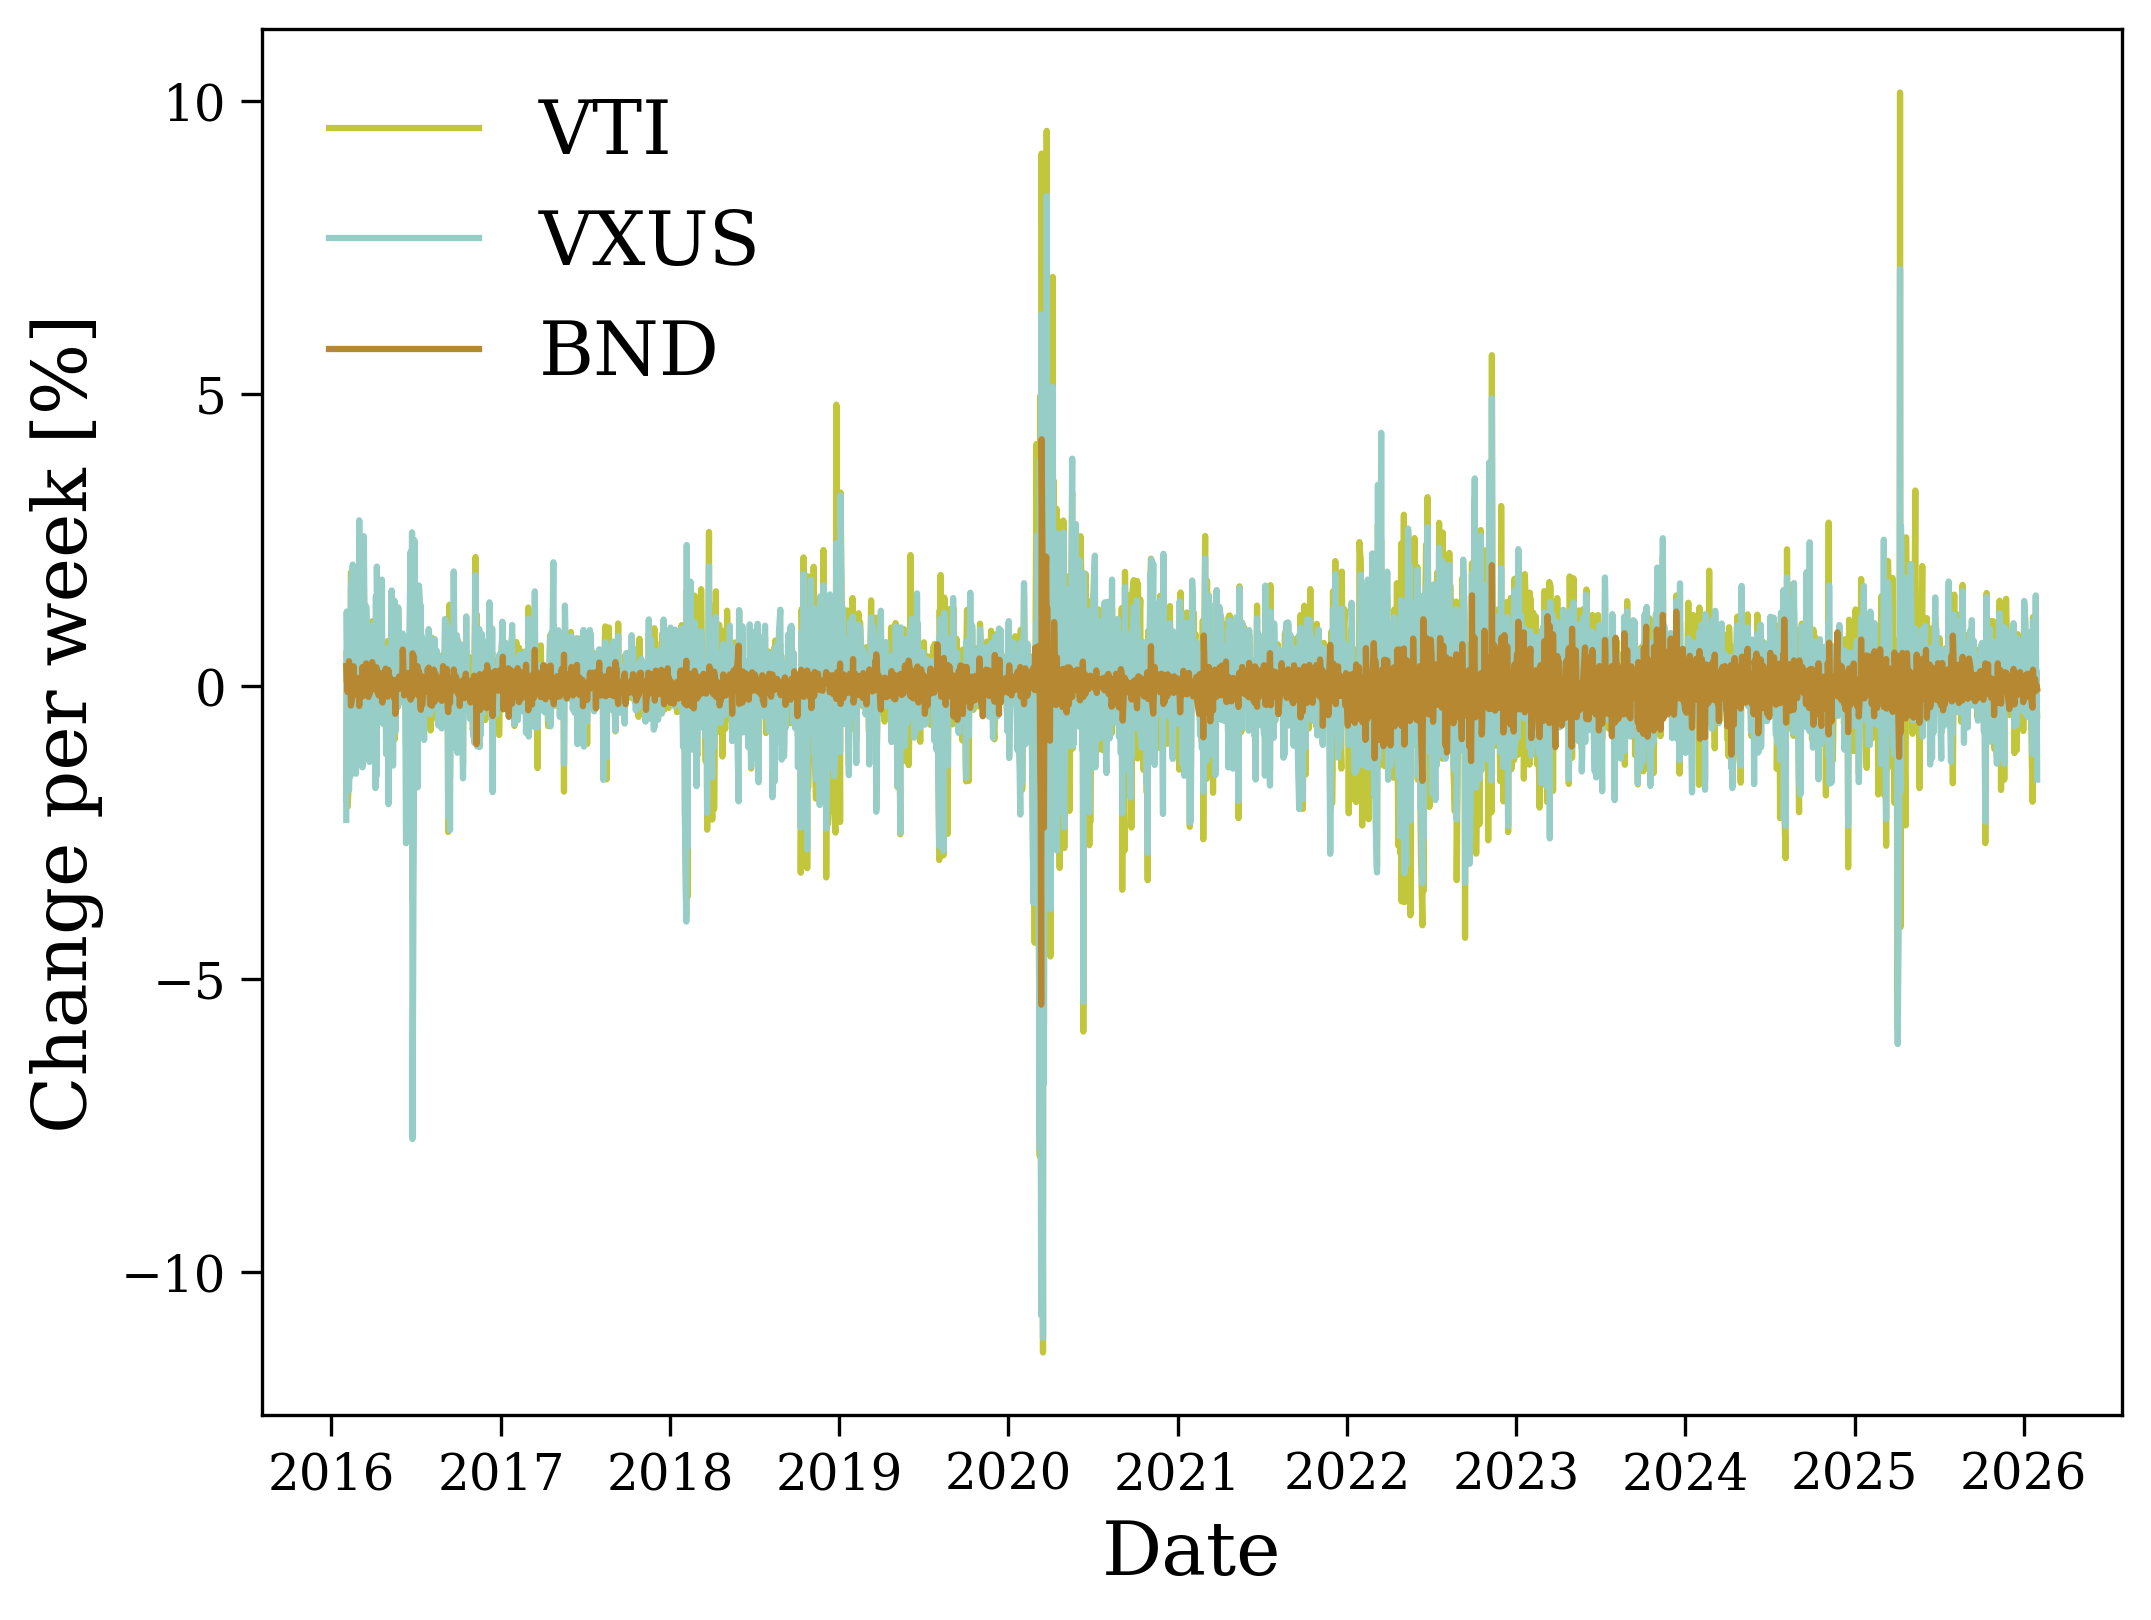

In [6]:
fig, ax = plt.subplots(figsize=single_column_figsize)

for ticker in tickers:
    ax.plot(returns.index, returns[ticker]*100, label=ticker)

ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Change per week [%]')

# **Gaussian Mixture Models**

We want to use a Gaussian mixture model to represent different regimes of the market. A [Gaussian mixture model (GMM)](https://towardsdatascience.com/gaussian-mixture-models-gmms-from-theory-to-implementation-4406c7fe9847/) is a probabilistic model that assumes the dataset is generated from a mixture of multiple Gaussian distributions. Unlike K-means clustering which is a hard clustering algorithm (separates the data points into clusters with a hard cutoff) and presumes similarly sized clusters, a GMM is a soft clustering algorithm which assigns each data point a probability of belonging to each cluster.

As described, a GMM is the sum of multiple normal distributions:

$$P(\mathbf{x_{i}}) = \sum_{j=1}^{K} \phi_{j} \mathcal{N}(\mathbf{x_{i}}|\mathbf{\mu_{j}}, \Sigma_{j})$$

When calculating the likelihood of a given dataset of returns, we assume that each return value for the week/day/etc. is independent of one another and identically distributed (i.i.d.) in order to use `sklearn`'s [built-in GMM function](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html). 

In reality, these returns are not i.i.d., but I make this assumption for simplicity because the rough overall picture is more important to me than local temporal correlations which are mostly captured in the covariance matrix anyways (e.g. if today we're in a bull market regime, it's more likely that tomorrow we continue to be in a bull market regime). But if one was more interested in modeling these temporal correlations more precisely, there exist models that can capture these transition periods between market regimes.

With this assumption, the GMM likelihood is then presumed to be the product of each return's probability distribution for $N$ return datapoints:

$$\mathcal{L} = \prod^{N}_{k=1} P(\mathbf{x_{k}}) $$

We do not have a labeled dataset typically (or else it would be easy to cluster!), so in order to work around this fact, it is standard to fit GMM with the iterative [expectation-maximization algorithm](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm) to find a (local) maximum likelihood. 

For each returns data vector, we compute the probability of being generated by each model component after assigning some set of parameters. Then, to maximize the expected log likelihood of the data given those assignments, the parameters are updated using the weighted averages of the data. Repeating this E-M process will eventually converge to a fitted GMM.

## How many Gaussians do we need?

In modeling the different market regimes, we do not want too many Gaussians or else we will overfit the data and each cluster will be meaningless. Too few clusters and we might not capture the full details of the data. **But how do we figure out what the right number of Gaussians to use?**

We can use one of two common metrics for evaluating model complexity in relation to its dataset. 

The Akaike information criterion (AIC) is defined as 

$$\mathrm{AIC} = 2p - 2ln(\mathcal{L})$$

in which $p$ is the number of parameters in the model and $\mathcal{L}$ is the likelihood function. The purpose of the AIC is to see what the largest model one can have while minimizing loss of information. As the model gains more parameters, there is a tradeoff of how much information is lost through the introduction of parameters and how well the model represents the data (i.e. the likelihood).

The Bayesian information criterion (BIC) is similar except it scales the number of parameters differently, and unlike the AIC which can favor more complex models, the BIC punishes overly complex models more than the AIC does and includes $N$ for the number of data points:

$$\mathrm{BIC} = pln(N) - 2ln(\mathcal{L})$$

Text(0, 0.5, 'Criterion')

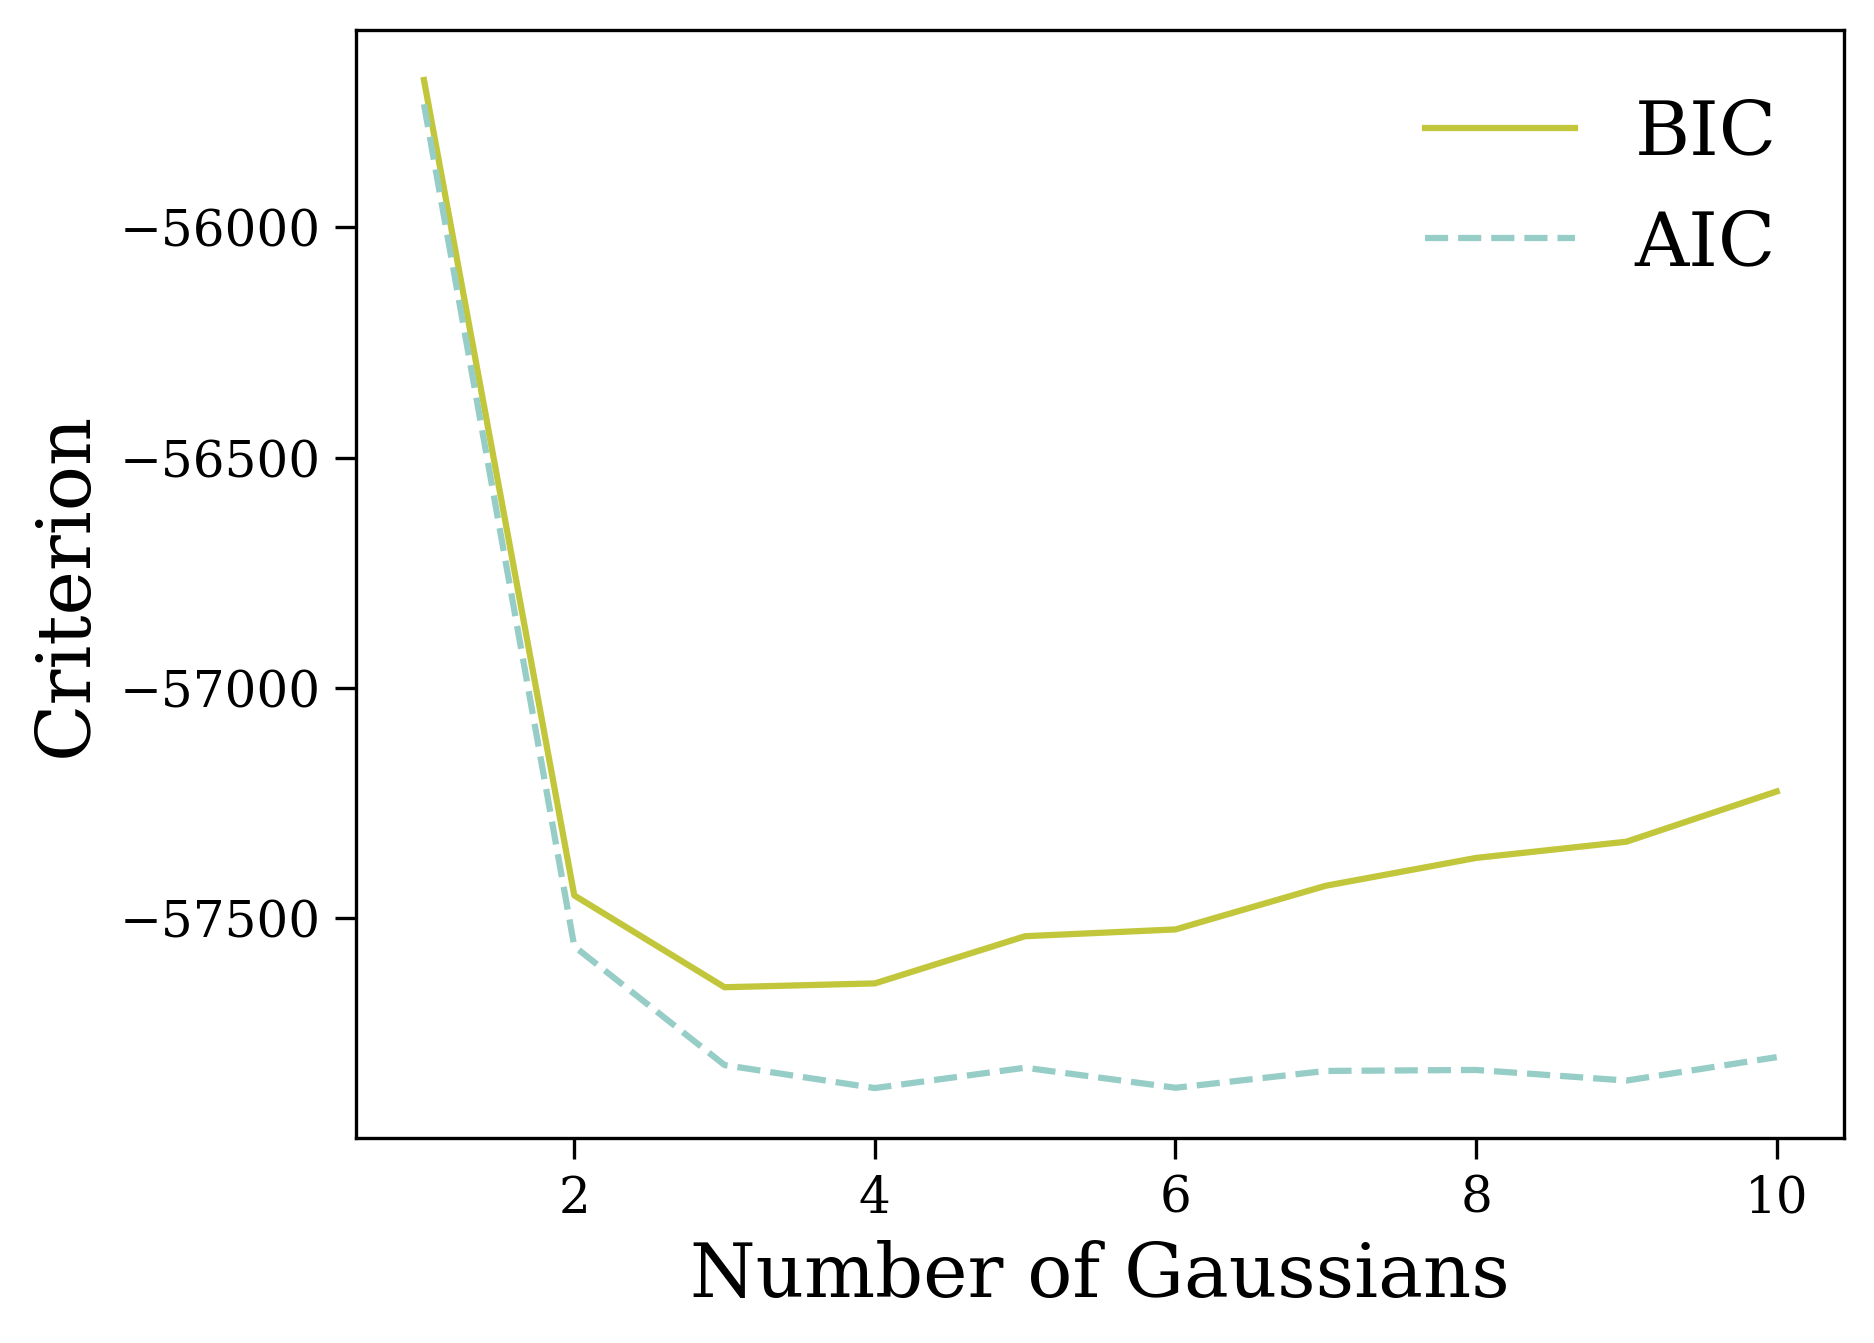

In [7]:
N = 10

bic = np.zeros(N)
aic = np.zeros(N)

for i in range(0,N):
    gmm = GaussianMixture(n_components=i+1)
    fit = gmm.fit(returns)
    bic[i] = gmm.bic(returns)
    aic[i] = gmm.aic(returns)

plt.plot(range(1,N+1), bic, '-', label='BIC')
plt.plot(range(1,N+1), aic, '--', label='AIC')
plt.legend()
plt.xlabel('Number of Gaussians')
plt.ylabel('Criterion')

BIC heavily disfavors complex models compared to AIC, but judging from the figure above, both metrics suggest no significant improvement after 3 or 4 normal distributions. To keep this simple, let's use 3 Gaussians. This also seems standard in the literature for identifying three market regimes (bull, bear, neutral) as described [here](https://oae.pubpub.org/pub/4gu2gl5g/release/1).

## Daily or weekly?

Interestingly, if you only take the returns weekly instead of daily, the AIC and BIC show no significant improvement after 2 Gaussians.

[*********************100%***********************]  3 of 3 completed


Text(0, 0.5, 'Criterion')

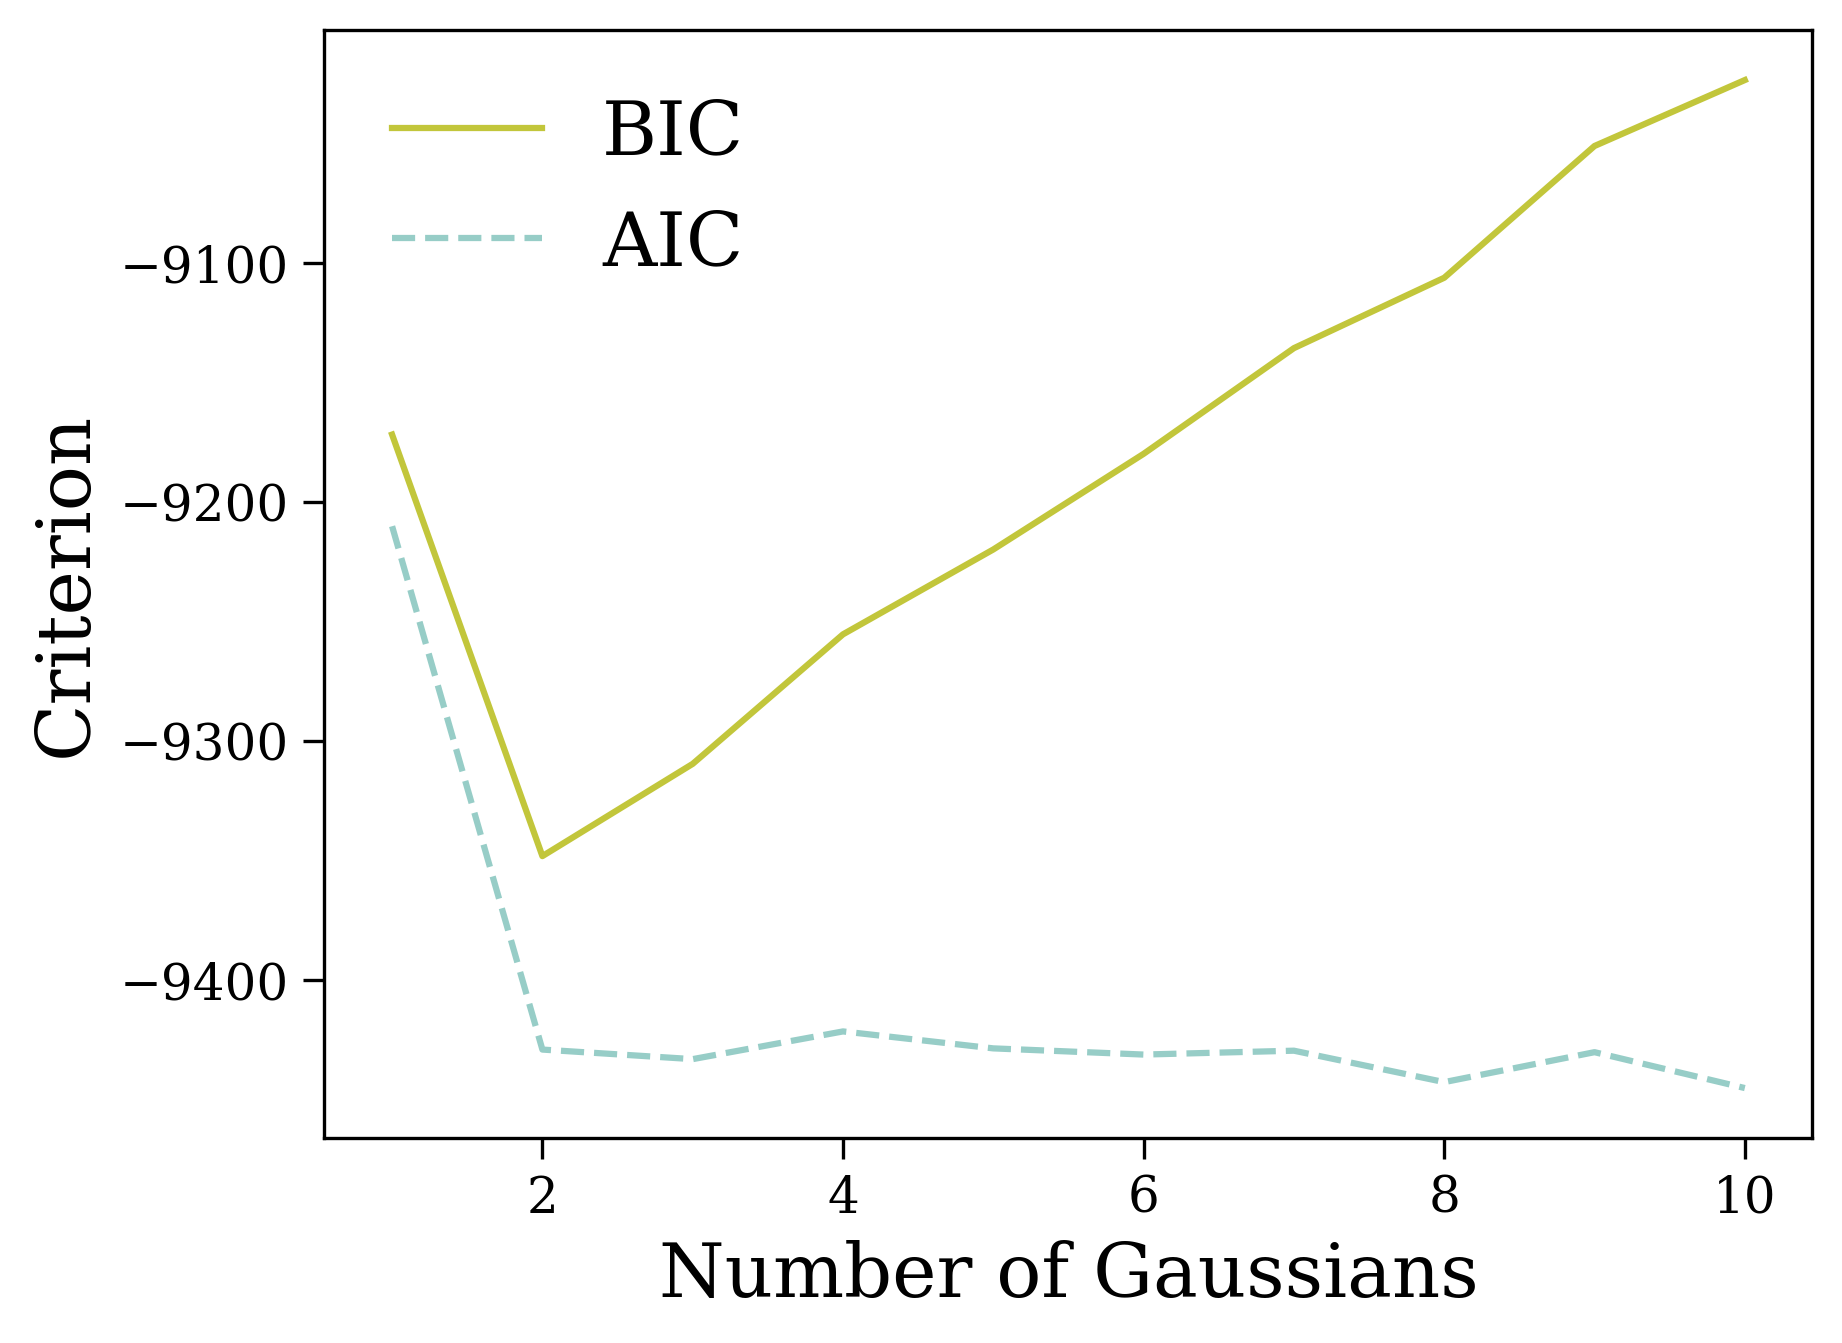

In [10]:
weekly_data = yf.download(tickers, period="10y", interval="1wk")

weekly_prices = weekly_data["Close"]

weekly_returns = weekly_prices.pct_change().dropna()

N = 10

w_bic = np.zeros(N)
w_aic = np.zeros(N)

for i in range(0,N):
    gmm = GaussianMixture(n_components=i+1)
    fit = gmm.fit(weekly_returns)
    w_bic[i] = gmm.bic(weekly_returns)
    w_aic[i] = gmm.aic(weekly_returns)

plt.plot(range(1,N+1), w_bic, '-', label='BIC')
plt.plot(range(1,N+1), w_aic, '--', label='AIC')
plt.legend()
plt.xlabel('Number of Gaussians')
plt.ylabel('Criterion')

We can test for performance of the method on both daily and weekly returns. 

## **Next Step: Optimizing for Portfolio Ratio?**

With our fitted GMM, we now have a model for the three- or two- regime market situation and we can now examine the space of all possible portfolio ratios. We can try out both and see what happens.